## Deploy  Helmet & Vest Detector for Worker Safety Model Package from AWS Marketplace 


Helmet & Vest Detector for Worker Safety - is a real-time image recognition and classification model for PPE non-compliance detection in the industrial setting. The ML model can be used in manufacturing, construction, steel, oil & gas, and other industrial environments. It detects the absence of helmet and vest on workers using object detection and real-time video analytics.

We also have a ready to use software, PPE Monitoring Platform: https://aws.amazon.com/marketplace/pp/B08BT5CV2F

We provide free support during the trial period! After you've succeeded with the subscription, reach out at support@vitechlab.com


This sample notebook shows you how to deploy [Helmet & Vest Detector for Worker Safety](https://aws.amazon.com/marketplace/pp/prodview-ky2uwngtqcwwq) using Amazon SageMaker.


#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to [Helmet & Vest Detector for Worker Safety](https://aws.amazon.com/marketplace/pp/prodview-ky2uwngtqcwwq). If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

#### Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Visualize output](#D.-Visualize-output)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Perform batch inference](#3.-Perform-batch-inference) 
4. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page [Helmet & Vest Detector for Worker Safety](https://aws.amazon.com/marketplace/pp/prodview-ky2uwngtqcwwq)
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

In [1]:
model_package_arn='<Customer to specify Model package ARN corresponding to their AWS region>'

In [2]:
import base64
import json 
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from urllib.parse import urlparse
import boto3
from IPython.display import Image, display
from PIL import Image as ImageEdit
from PIL import ImageDraw, ImageFont
import urllib.request
import numpy as np

In [ ]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket=sagemaker_session.default_bucket()
bucket

### 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [4]:
model_name='helmet-vest-detector-model'
content_type='image/jpeg'

real_time_inference_instance_type='ml.c5.2xlarge'
batch_transform_inference_instance_type='ml.p2.xlarge'

#### A. Create an endpoint

In [5]:
def predict_wrapper(endpoint, session):
    return sage.RealTimePredictor(endpoint, session,content_type)

#create a deployable model from the model package.
model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

#Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

---------------!

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

In [6]:
file_name = 'data/input/real-time/example.jpeg'

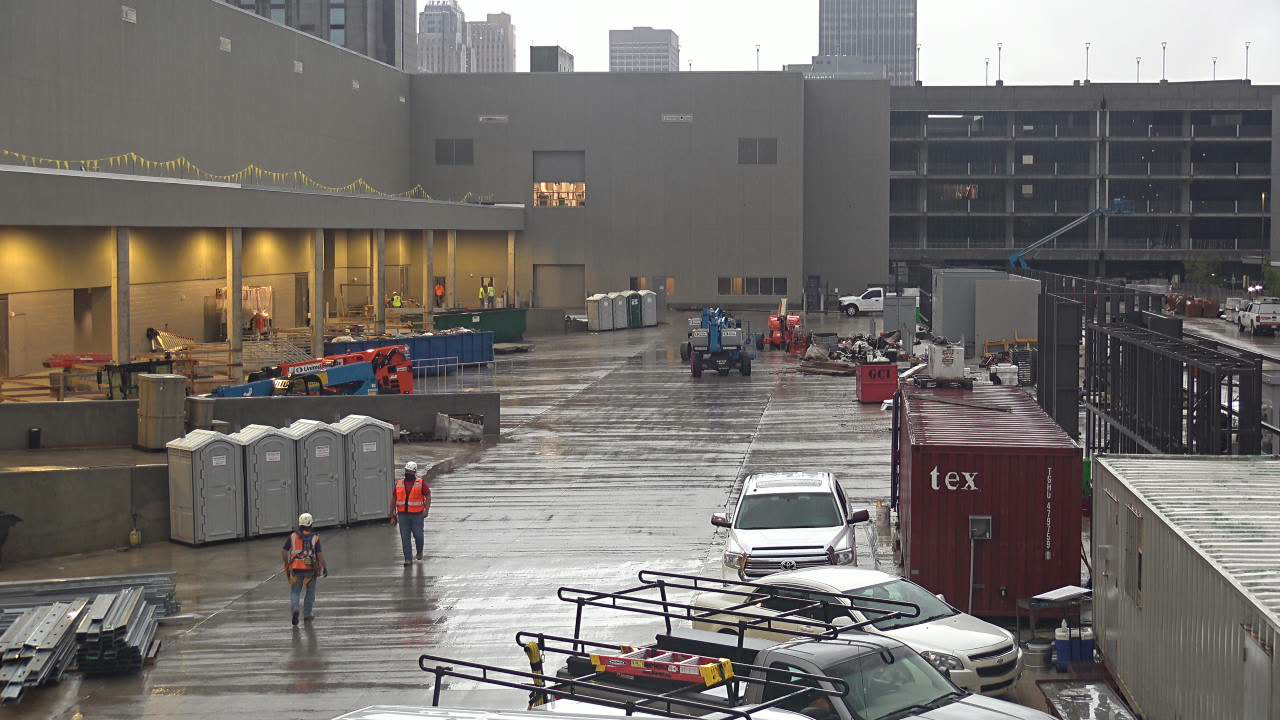

In [7]:
ImageEdit.open(file_name)

In [8]:
output_file_name = 'data/output/real-time/example.json'

#### C. Perform real-time inference

In [9]:
!aws sagemaker-runtime invoke-endpoint \
    --endpoint-name $model_name \
    --body fileb://$file_name \
    --content-type $content_type \
    --region $sagemaker_session.boto_region_name \
    $output_file_name

{
    "ContentType": "application/json",
    "InvokedProductionVariant": "AllTraffic"
}


#### D. Visualize output

In [10]:
def show_detections(file_name, output_file_name):
    confidence_threshold=80.0
    text_bg_height = 40
    text_bg_width = 130
    box_color = '#e0e0e0'
    text_box_color = '#e0e0e0b3'
    default_color = 'black'
    breach_color = '#ff0000'
    img = ImageEdit.open(file_name)
    drawing = ImageDraw.Draw(img, 'RGBA')

    with open(output_file_name, "r") as f:
        detections = json.load(f)

    for info in detections:
        if info["confidence"][0] > confidence_threshold:
            xmin, ymin, xmax, ymax = info['box_points']
            drawing.rectangle([xmin, ymin, xmax, ymax], outline=box_color, width=2)

            if ymin - text_bg_height < 0:
                ymin = ymin + text_bg_height

            drawing.rectangle([xmin, ymin - text_bg_height, xmin + text_bg_width, ymin], fill=text_box_color)

            text_offset = -18
            for label, label_confidence in info['classes'].items():
                color = breach_color if label_confidence > 50.0 else default_color

                drawing.text((xmin, ymin + text_offset),
                             f'{label}: {label_confidence:.0f}%',
                             font=ImageFont.load_default(),
                             fill=color)
                text_offset -= 18

    display(img)

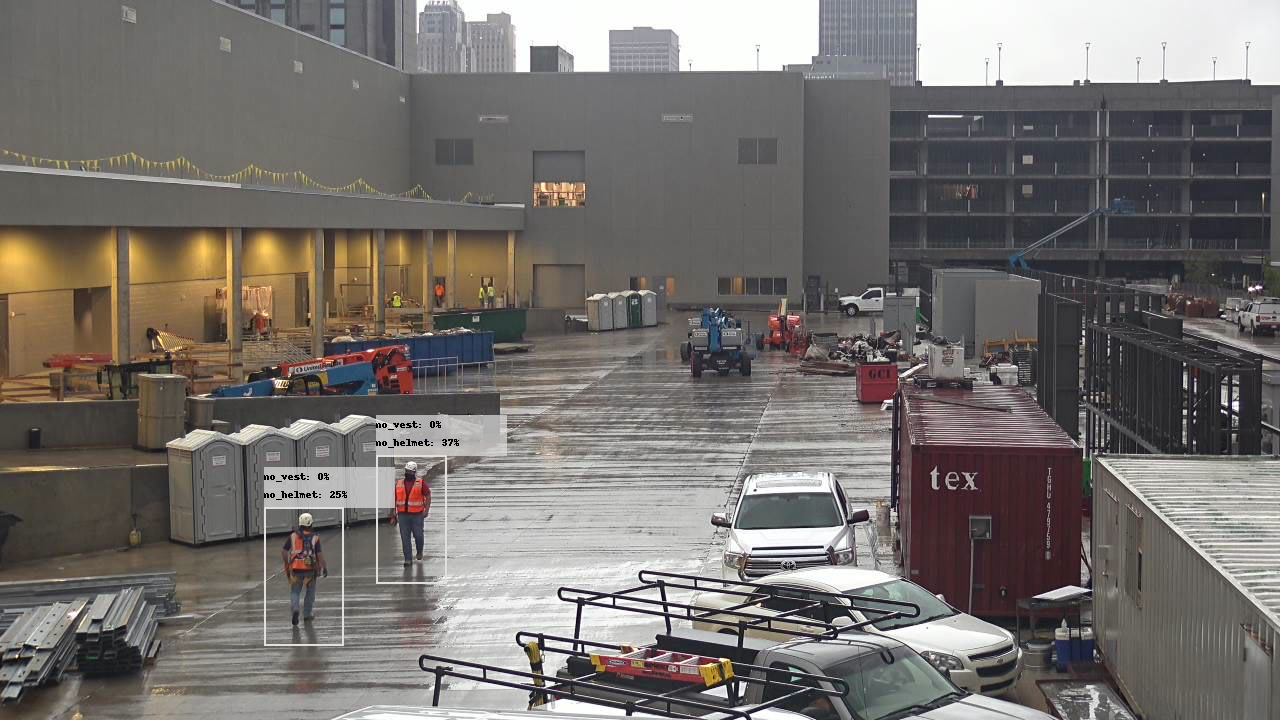

In [11]:
show_detections(file_name, output_file_name)

#### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [12]:
predictor=sage.RealTimePredictor(model_name, sagemaker_session,content_type)
predictor.delete_endpoint(delete_endpoint_config=True)

### 3. Perform batch inference

In this section, you will perform batch inference using multiple input payloads together. If you are not familiar with batch transform, and want to learn more, see these links:
1. [How it works](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)
2. [How to run a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html)

In [ ]:
#upload the batch-transform job input files to S3
transform_input_folder = "data/input/batch"
transform_input = sagemaker_session.upload_data(transform_input_folder, key_prefix=model_name) 
print("Transform input uploaded to " + transform_input)

In [14]:
#Run the batch-transform job
transformer = model.transformer(1, batch_transform_inference_instance_type)
transformer.transform(transform_input, content_type=content_type)
transformer.wait()

Using already existing model: ppe-detector-v3-2020-08-21-11-58-52-093


........................................2020-08-21T12:13:16.522:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Starting the inference server with 1 workers.
model_server_timeout is 300
2020/08/21 12:13:12 [crit] 10#10: *1 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 169.254.255.130, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "169.254.255.131:8080"
Starting the inference server with 1 workers.
model_server_timeout is 300
2020/08/21 12:13:12 [crit] 10#10: *1 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 169.254.255.130, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "169.254.255.131:8080"
169.254.255.130 - - [21/Aug/2020:12:13:12 +0000] "GET /ping HTTP/1.1" 502 182 "-" "Go-http-client/1.1"
2020/08/21 12:13:12 [

In [ ]:
#output is available on following path
transformer.output_path

### 4. Clean-up

#### A. Delete the model

In [16]:
model.delete_model()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

